In [1]:
# COLAB ONLY CELLS
try:
    import google.colab
    IN_COLAB = True
    !pip install -U gensim  # Install gensim 4
    !nvidia-smi             # Check which GPU has been chosen for us
    !rm -rf logs
except:
    IN_COLAB = False

# Assignment 1

## Data Preprocessing

### Imports

In [2]:
%load_ext tensorboard

import os
import requests
import zipfile
from tqdm import tqdm
import time
import random
import datetime
from IPython.display import display
from functools import partial

from typing import List, Dict, Callable, Sequence, Tuple

from sklearn.metrics import f1_score, confusion_matrix, ConfusionMatrixDisplay

import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

import gensim
import gensim.downloader as gloader
assert int(gensim.__version__.split('.')[0]) >= 4, "Install gensim 4.x.x or above (pip install -U gensim)"

%matplotlib inline

BATCH_SIZE = 128

# Fix random seed for reproducibility
RANDOM_SEED = 128
np.random.seed(RANDOM_SEED)
random.seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)

### Downloading the Dataset

In [3]:
ROOT_PATH = os.path.dirname(os.getcwd())
DATA_PATH = os.path.join(ROOT_PATH, 'data')

def save_response_content(response, destination):
    CHUNK_SIZE = 32768

    with open(destination, "wb") as f:
        for chunk in response.iter_content(CHUNK_SIZE):
            if chunk: # filter out keep-alive new chunks
                f.write(chunk)

def download_data(data_path):
    final_path = os.path.join(data_path, 'dependency_treebank.zip')
    url = "https://raw.githubusercontent.com/nltk/nltk_data/gh-pages/packages/corpora/dependency_treebank.zip"

    if not os.path.exists(data_path):
        os.makedirs(data_path)

    if not os.path.exists(final_path):
        print("Downloading dataset...")
        with requests.Session() as current_session:
            response = current_session.get(url, stream=True)
        save_response_content(response, final_path)
        print("Download completed!")

        print("Extracting dataset...")
        with zipfile.ZipFile(final_path) as loaded_zip:
            loaded_zip.extractall(data_path)
        print("Extraction completed!")

download_data(DATA_PATH)

# The new data path is:
DATA_PATH = os.path.join(DATA_PATH, 'dependency_treebank')

### Dataset Exploration

The dataset is composed of several files whose naming convention is `wsj_{num}.dp`. We explore the content of the first file:

In [4]:
with open(os.path.join(DATA_PATH, 'wsj_0001.dp'), 'r') as f:
    lines = [l.rstrip() for l in f.readlines()]

print(lines)

['Pierre\tNNP\t2', 'Vinken\tNNP\t8', ',\t,\t2', '61\tCD\t5', 'years\tNNS\t6', 'old\tJJ\t2', ',\t,\t2', 'will\tMD\t0', 'join\tVB\t8', 'the\tDT\t11', 'board\tNN\t9', 'as\tIN\t9', 'a\tDT\t15', 'nonexecutive\tJJ\t15', 'director\tNN\t12', 'Nov.\tNNP\t9', '29\tCD\t16', '.\t.\t8', '', 'Mr.\tNNP\t2', 'Vinken\tNNP\t3', 'is\tVBZ\t0', 'chairman\tNN\t3', 'of\tIN\t4', 'Elsevier\tNNP\t7', 'N.V.\tNNP\t12', ',\t,\t12', 'the\tDT\t12', 'Dutch\tNNP\t12', 'publishing\tVBG\t12', 'group\tNN\t5', '.\t.\t3']


Each file contains a paragraph of text, optionally composed of multiple sentences. 

The paragraph is structured as a sequence of lines, each line containing a word, a tag and a number separated by `\t` tags. We don't care about the number, so we ignore the third element.

We can define a function that given a file processes its content and returns a Pandas `DataFrame` for each sentence extracted from the file.

In [30]:
def process_file(filepath: str):
    with open(filepath, 'r') as f:
        # They are not technically csv files, but they are text files
        # so we can still use the same function.
        df = pd.read_csv(f, sep='\t', names=['word','tag','drop'])
    # Drop the last column
    df = df.drop(['drop'], axis=1)
    # Find indices of the dataframe categorized as points
    # meaning we have found the beginning of a new sentence.
    points_indices = df.index[df['tag'] == '.']
    
    # Split dataframes based on those indices
    sentences = []
    last_index = 0
    for idx in points_indices:
        sentences.append(df.iloc[last_index:idx+1])
        last_index = idx+1
    return sentences

# Example:
test_sentences = process_file(os.path.join(DATA_PATH, 'wsj_0001.dp'))
for sentence in test_sentences:
    display(sentence)

,word,tag
0,Pierre,NNP
1,Vinken,NNP
2,",",","
3,61,CD
4,years,NNS
5,old,JJ
6,",",","
7,will,MD
8,join,VB
9,the,DT


,word,tag
18,Mr.,NNP
19,Vinken,NNP
20,is,VBZ
21,chairman,NN
22,of,IN
23,Elsevier,NNP
24,N.V.,NNP
25,",",","
26,the,DT
27,Dutch,NNP


### Dataset splits

We are required to split the dataset using:
- Documents 1-100 as the train set.
- Documents 101-150 as the validation set.
- Documents 151-199 as the test set.

First, we compute all filenames for the splits.

In [31]:
train_filenames = [ os.path.join(DATA_PATH, 'wsj_{:04d}.dp'.format(x)) for x in range(1  , 101) ] 
val_filenames   = [ os.path.join(DATA_PATH, 'wsj_{:04d}.dp'.format(x)) for x in range(101, 151) ]
test_filenames  = [ os.path.join(DATA_PATH, 'wsj_{:04d}.dp'.format(x)) for x in range(151, 200) ]

Then, we translate the filenames into dataframes.

In [32]:
train_sentences = [ sentence for file in train_filenames for sentence in process_file(file) ]
val_sentences   = [ sentence for file in val_filenames   for sentence in process_file(file) ]
test_sentences  = [ sentence for file in test_filenames  for sentence in process_file(file) ]

Here we define some utility functions that we can use to obtain sentences in other forms.

In [33]:
def get_list_of_words_from_sentence(sentence: pd.DataFrame):
    return list(sentence['word'])

def get_natural_language_sentence(sentence):
    if isinstance(sentence, pd.DataFrame):
        sentence = get_list_of_words_from_sentence(sentence)
    return " ".join(sentence)

sen_test = train_sentences[1]
print(get_list_of_words_from_sentence(sen_test))
print(get_natural_language_sentence(sen_test))

['Mr.', 'Vinken', 'is', 'chairman', 'of', 'Elsevier', 'N.V.', ',', 'the', 'Dutch', 'publishing', 'group', '.']
Mr. Vinken is chairman of Elsevier N.V. , the Dutch publishing group .


### Dataset Analysis

We study the distribution of the sentences and the tags.

There are 1959 training sentences
There are 1277 validation sentences
There are 638 test sentences


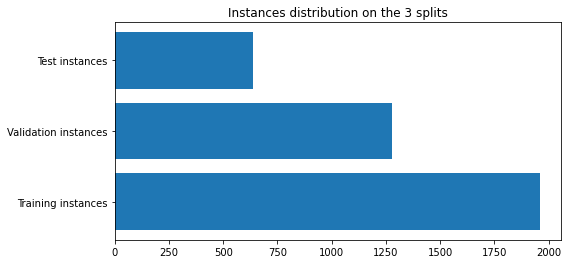

In [34]:
def plot_instances(train_size, val_size, test_size):
    x_values = [train_size, val_size, test_size]
    y_values = ["Training instances", "Validation instances", "Test instances"]
    y_axis = np.arange(1, 4, 1)
    plt.figure(figsize=(8,4))
    plt.title("Instances distribution on the 3 splits")
    plt.barh(y_axis, x_values, align='center')
    plt.yticks(y_axis, y_values)
    plt.show()

train_size = len(train_sentences)
val_size = len(val_sentences)
test_size = len(test_sentences)
print("There are {} training sentences".format(train_size))
print("There are {} validation sentences".format(val_size))
print("There are {} test sentences".format(test_size))

plot_instances(train_size, val_size, test_size)

Let's compute the average sentence length.

The average sentence length in the training set is 24.17203 with an std of 12.66482 and a max of 250
The average sentence length in the validation set is 24.41895 with an std of 11.68467 and a max of 80
The average sentence length in the test set is 24.36520 with an std of 10.05751 and a max of 80


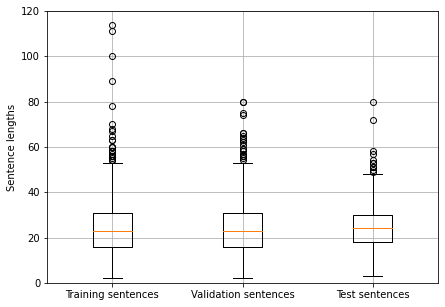

In [35]:
len_train = [len(sentence) for sentence in train_sentences]
len_val   = [len(sentence) for sentence in val_sentences  ]
len_test  = [len(sentence) for sentence in test_sentences ]

mean_train, std_train, max_train = np.mean(len_train), np.std(len_train), np.max(len_train)
mean_val, std_val, max_val = np.mean(len_val), np.std(len_val), np.max(len_val)
mean_test, std_test, max_test = np.mean(len_test), np.std(len_test), np.max(len_test)

print("The average sentence length in the training set is {:.5f} with an std of {:.5f} and a max of {}".format(
    mean_train, std_train, max_train
))
print("The average sentence length in the validation set is {:.5f} with an std of {:.5f} and a max of {}".format(
    mean_val, std_val, max_val
))
print("The average sentence length in the test set is {:.5f} with an std of {:.5f} and a max of {}".format(
    mean_test, std_test, max_test
))

len_dict = {'Training sentences':    len_train, 
            'Validation sentences':  len_val, 
            'Test sentences':        len_test}

fig, ax = plt.subplots(figsize=(7,5));
ax.boxplot(len_dict.values());
ax.set_xticklabels(len_dict.keys());
ax.set_ylim(0, 120)
ax.set_ylabel("Sentence lengths")
ax.grid()

The sentences seem to have approximately the same distribution between the three splits, but there are some clear outliers in the training set.

We also compute the distribution of the tags.

,word
tag,
NN,13166
IN,9857
NNP,9408
DT,8165
NNS,6047
JJ,5834
",",4886
.,3874
CD,3546


Total number of tags:  94081


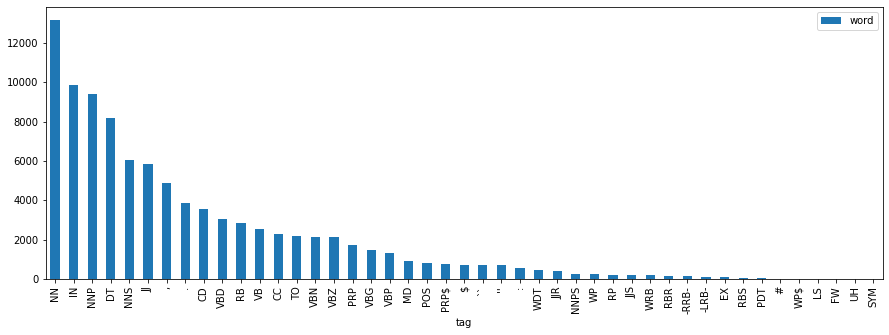

In [36]:
tags_distribution = pd.concat(train_sentences + val_sentences + test_sentences, axis=0).groupby(['tag']).count()

sorted_tags_distribution = tags_distribution.sort_values(by='word', ascending=False)
ax = sorted_tags_distribution.plot(kind='bar', figsize=(15, 5))
ax.set_xticklabels(sorted_tags_distribution.index)
display(sorted_tags_distribution.head(20))
print("Total number of tags: ", tags_distribution['word'].sum())

Note: see [here](https://www.ling.upenn.edu/courses/Fall_2003/ling001/penn_treebank_pos.html) for the explanation of each tag. Some of the tags simply indicate punctuation.

In [37]:
PUNCTUATION_TAGS = ["#", "$", "''", ",", ".", ":", "``", "-LRB-", "-RRB-", "SYM"]
print("There are {} punctuation tags in the dataset".format(
    sum([ tags_distribution.loc[pun] for pun in PUNCTUATION_TAGS ])['word']
))

There are 11715 punctuation tags in the dataset


### Data Preprocessing

In this task, we don't want to remove words because we should provide a one-to-one mapping from words to tags.

Therefore, the only sensible preprocessing we can do on the sentences is to bring everything to lowercase.

In [39]:
def to_lower(word: str):
    return word.lower()

for sentence_group in [train_sentences, val_sentences, test_sentences]:
    for sentence in sentence_group:
        sentence['word'] = sentence['word'].apply(to_lower)

train_sentences[1]

,word,tag
18,mr.,NNP
19,vinken,NNP
20,is,VBZ
21,chairman,NN
22,of,IN
23,elsevier,NNP
24,n.v.,NNP
25,",",","
26,the,DT
27,dutch,NNP


## Embeddings

We download GloVe's pretrained embeddings with dimension 100 using the Gensim library.

In [40]:
def load_embedding_model(embedding_dimension: int = 50) -> gensim.models.keyedvectors.KeyedVectors:
    """
    Loads GloVe pre-trained word embedding model via gensim library.

    Parameters:
    - embedding_dimension: size of the embedding space to consider

    Returns:
        - pre-trained word embedding model (gensim KeyedVectors object)
    """
    assert embedding_dimension in {50,100,200,300}, "Embedding dimension must be one of 50,100,200,300"
    download_path = "glove-wiki-gigaword-{}".format(embedding_dimension)
    try:
        emb_model = gloader.load(download_path)
    except:
        print("ERROR: No Internet connection available")
        return None
    return emb_model

EMBEDDING_DIMENSION = 100
embedding_model = load_embedding_model(EMBEDDING_DIMENSION)

### GloVe's vocabulary

We use as initial vocabulary the vocabulary of GloVe's pretrained embeddings.

In [41]:
embedding_vocabulary = set(embedding_model.index_to_key)
print("Starting vocabulary contains {} words.".format(len(embedding_vocabulary)))

Starting vocabulary contains 400000 words.


The vocabulary of the embeddings may not contain all the words that are used in our sentences, so we need to create sensible encodings for OOV words and add them to the vocabulary.

A smart idea to create OOV embeddings is to obtain the mean and standard deviation of the GloVe embeddings and to sample new random vectors from a reduced uniform distribution with those parameters. In this way, we make sure that OOV embeddings are at least similar to the real embeddings.

In [42]:
# Create an empty matrix that should hold all the embeddings of GloVe's vocabulary
def create_embedding_matrix(embedding_model: gensim.models.keyedvectors.KeyedVectors):
    embedding_vocabulary = set(embedding_model.index_to_key)
    embedding_matrix = np.zeros((len(embedding_vocabulary), EMBEDDING_DIMENSION), dtype=np.float32)

    # Loop through the words of the vocabulary
    for idx, word in tqdm(enumerate(embedding_model.index_to_key), total=len(embedding_vocabulary)):
        try:
            # Get the vector representation of the word according to the embedding model
            embedding_vector = embedding_model[word]
            # Set the corresponding row to the embedding vector
            embedding_matrix[idx] = embedding_vector
        except (KeyError, TypeError):
            pass
    
    return embedding_matrix

embedding_matrix = create_embedding_matrix(embedding_model)

# Calculate mean and standard deviation
glove_mean = embedding_matrix.mean()
glove_std = embedding_matrix.std()

print("Mean embedding vector: {}".format(glove_mean))
print("Std of embedding vectors: {}".format(glove_std))

100%|███████████████████████████████████████████████████████████████████████| 400000/400000 [00:00<00:00, 573670.84it/s]


Mean embedding vector: 0.004451991990208626
Std of embedding vectors: 0.4081574082374573


Then we can define a function to create random embeddings for OOV words.

In [43]:
def get_random_embedding():
    return np.random.uniform(low=glove_mean-glove_std/10, 
        high=glove_mean+glove_std/10, size=EMBEDDING_DIMENSION
    )

### OOV terms

We find all OOV terms in the splits independently and build our vocabularies and embedding matrix. 

#### Training OOV terms

In [44]:
# Step 1: Obtain a set of words (vocabulary) used in each split
def get_set_of_words_for_sentences(sentence_seq: Sequence[pd.DataFrame]):
    return set(
        pd.concat(sentence_seq, axis=0).    # Concatenate all sentences together
        groupby(['word']).                  # Group by words
        indices.keys()                      # Obtain the sequence of words
    )             

train_vocabulary = get_set_of_words_for_sentences(train_sentences)
val_vocabulary = get_set_of_words_for_sentences(val_sentences)
test_vocabulary = get_set_of_words_for_sentences(test_sentences)

In [45]:
# Step 2: Find OOV words with respect to some vocabulary
def get_OOV_terms(vocab_1: set, vocab_2: set):
    return vocab_1.difference(vocab_2)

oov_train = get_OOV_terms(train_vocabulary, embedding_vocabulary)

print("DEBUG: Training set has {} OOV terms over {} total terms ({:.2f}%)".format(
    len(oov_train), len(train_vocabulary), len(oov_train)/len(train_vocabulary)*100
))
print("Some OOV terms:")
print(list(oov_train)[:30])

DEBUG: Training set has 359 OOV terms over 7402 total terms (4.85%)
Some OOV terms:
['family-planning', 'red-blooded', 'flightiness', 'test-prep', 'gingl', 'erbamont', 'trading-company', 'rubinfien', '14,821', 'more-efficient', 'test-preparation', 'food-shop', 'social-studies', 'program-trading', 'market-share', 'sub-markets', '18,444', '278.7', 'mouth-up', 'detective-story', 'savings-and-loan', 'government-certified', 'ingersoll-rand', '497.34', '2645.90', 'macmillan\\/mcgraw', '142.85', 'solaia', 'pre-1933', 'secilia']


OOVs (for the training set) seem to mostly be: 
- hyphenated compound words
- numbers
- foreign words
- other uncommon words

We update the vocabulary adding these OOV words.

In [46]:
embedding_model.add_vectors(list(oov_train), 
    np.stack([get_random_embedding() for _ in range(len(oov_train))])
)
train_embedding_vocabulary = set(embedding_model.index_to_key)

print("New length of the embedding model: {}".format(len(train_embedding_vocabulary)))

New length of the embedding model: 400359


We repeat the process for the evaluation and test sets.

#### Validation OOV terms

In [47]:
# Find OOV words
oov_val = get_OOV_terms(val_vocabulary, train_embedding_vocabulary)
print("DEBUG: Validation set has {} OOV terms over {} total terms ({:.2f}%)".format(
    len(oov_val), len(val_vocabulary), len(oov_val)/len(val_vocabulary)*100
))
print("Some OOV terms:")
print(list(oov_val)[:30])

# Update the model
embedding_model.add_vectors(list(oov_val), 
    np.stack([get_random_embedding() for _ in range(len(oov_val))])
)
val_embedding_vocabulary = set(embedding_model.index_to_key)

print("New length of the embedding model: {}".format(len(val_embedding_vocabulary)))

DEBUG: Validation set has 189 OOV terms over 5420 total terms (3.49%)
Some OOV terms:
['cup-tote', 'liquid-nitrogen', 'anti-program', 'triple-a-rated', 'million-a-year', 'airline-related', 'mega-stadium', 'rey\\/fawcett', 'car-care', 'new-car', 'single-lot', '7\\/16', 'boogieman', 'lightning-fast', 'non-callable', 'parts-engineering', 'pricings', '3,250,000', 'investment-grade', 'bank-backed', '5.435', '30,537', 'super-absorbent', 'high-polluting', 'crystal-lattice', 'foldability', 'lynch-mob', 'tire-kickers', 'multi-crystal', 'yttrium-containing']
New length of the embedding model: 400548


#### Test OOV terms

In [48]:
# Find OOV words
oov_test = get_OOV_terms(test_vocabulary, val_embedding_vocabulary)
print("DEBUG: Test set has {} OOV terms over {} total terms ({:.2f}%)".format(
    len(oov_test), len(test_vocabulary), len(oov_test)/len(test_vocabulary)*100
))
print("Some OOV terms:")
print(list(oov_test)[:30])

# Update the model
embedding_model.add_vectors(list(oov_test), 
    np.stack([get_random_embedding() for _ in range(len(oov_test))])
)
test_embedding_vocabulary = set(embedding_model.index_to_key)

print("New length of the embedding model: {}".format(len(test_embedding_vocabulary)))

DEBUG: Test set has 128 OOV terms over 3407 total terms (3.76%)
Some OOV terms:
['372.14', 'weapons-modernization', 'waertsilae', '38.875', 'nofzinger', 'louisiana-pacific', 'yoshihashi', '45-a-share', '34.625', 'above-market', 'cash-and-stock', '11,390,000', 'heavy-truck', 'sewing-machine', 'tete-a-tete', 'computer-services', '292.32', 'near-limit', 'copper-rich', 'constitutional-law', 'johnson-era', 'acquisition-minded', 'cents-a-unit', 'shareholder-rights', '1206.26', 'mariotta', 'launch-vehicle', '87-store', 'lentjes', 'g.m.b']
New length of the embedding model: 400676


#### Summary

In general, we notice the same pattern we have exposed for training OOV terms also in the OOV of the other splits. 

Additionally, we report that the number of OOV terms is always less than 5% in all splits, so they shouldn't be a big problem.

### Padding

It's time to think some steps ahead: when we feed our sentences to the model, we usually provide mini-batches of data (for example, a set of 128 sentences at a time). This makes training faster and more stable.

A mini-batch of data should be "rectangular", meaning that sentences should all have the same number of words. Usually, this translates to using **padding** in the sentences, filling the vectors representing the sentences with zeroes up to a predetermined size.

In [49]:
embedding_model.add_vector('<PAD>', np.zeros(EMBEDDING_DIMENSION)); # The embedding is a vector of zeroes

/home/volpepe/Desktop/SequenceLabeling/.env/lib/python3.8/site-packages/gensim/models/keyedvectors.py:478: UserWarning: Adding single vectors to a KeyedVectors which grows by one each time can be costly. Consider adding in batches or preallocating to the required size.
  warnings.warn(


We should check what the index of the padding vector is.

In [50]:
PADDING_IDX = embedding_model.key_to_index['<PAD>']
PADDING_IDX

400676

We would like to have the padding token as element 0 (because it can be automatically masked when using [Keras's Embedding Layer](https://keras.io/api/layers/core_layers/embedding/)).

### Final embedding matrix

In [51]:
embedding_matrix = create_embedding_matrix(embedding_model)
# We need to move the row where the padding index is at the first row and shift the rest of the matrix by 1
embedding_matrix = np.append(embedding_matrix[-1:, :], embedding_matrix[:-1, :], axis=0)
print("DEBUG: Embedding matrix shape: {}".format(embedding_matrix.shape))

100%|███████████████████████████████████████████████████████████████████████| 400677/400677 [00:00<00:00, 638351.00it/s]

DEBUG: Embedding matrix shape: (400677, 100)


## Baseline model

In this section, we will transform our data so that it's easier to process for our models and build our first baseline model.

### Dataset processing pipeline

First of all, we should provide some utility functions to facilitate inputting data to the networks.

We have decided to use TensorFlow's [Dataset](https://www.tensorflow.org/api_docs/python/tf/data/Dataset) class, since it provides many useful functions for dealing with batches and building efficient data preprocessing pipelines.

In [52]:
# A function that converts a sentence to a list of indices indexing the created vocabulary model
def sentence_to_idxs(sentence: pd.DataFrame):
    sentence_list = get_list_of_words_from_sentence(sentence)
    return [ embedding_model.key_to_index[word] + 1 for word in sentence_list ] # +1 for padding

print("DEBUG: indexes for sentence '{}':".format(get_natural_language_sentence(train_sentences[1])))
sentence_to_idxs(train_sentences[1])

DEBUG: indexes for sentence 'mr. vinken is chairman of elsevier n.v. , the dutch publishing group .':


[1996, 400183, 15, 664, 4, 43651, 60024, 2, 1, 1693, 3649, 130, 3]

We apply this function to the entire dataset splits.

In [53]:
X_train = [ sentence_to_idxs(sentence) for sentence in train_sentences ]
X_val   = [ sentence_to_idxs(sentence) for sentence in val_sentences   ]
X_test  = [ sentence_to_idxs(sentence) for sentence in test_sentences  ]

We use [a Tensorflow function](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/sequence/pad_sequences) to automatically apply padding to the sequences.

In theory, padding should bring all tensors to have as many elements as the longest sentence. We have analyzed before that the training set has some outliers and the longest sequence contains 250 elements, but bringing all sequences to have 250 elements is clearly a waste of memory.

Instead, we choose to fix a maximum length similar to the other splits. This will cut a part of the outlier training sentences, but since they are only used for training it shouldn't be a big problem.

In [54]:
print("Max length in training set: {}".format(max_train))
print("Max length in validation set: {}".format(max_val))
print("Max length in test set: {}".format(max_test))

Max length in training set: 250
Max length in validation set: 80
Max length in test set: 80


In [55]:
SEQ_MAX_LEN = max(max_val, max_test)
print("We choose {} as maximum length".format(SEQ_MAX_LEN))

We choose 80 as maximum length


If we choose 88 as maximum length for all sequences, only a very small part of the training sentences are cut.

In [56]:
kept_sentences = np.sum(len_train < SEQ_MAX_LEN)
total_sentences = len(len_train)
print("We keep {}/{} (over {:.4f}%) of the training sentences".format(
    kept_sentences, total_sentences, 
    kept_sentences / total_sentences * 100
))

We keep 1954/1959 (over 99.7448%) of the training sentences


In [57]:
X_train = keras.preprocessing.sequence.pad_sequences(
    X_train, maxlen=SEQ_MAX_LEN, truncating='post',   # truncating='post' means that we cut the last part of the sentence
    padding='post'
)

X_val = keras.preprocessing.sequence.pad_sequences(X_val, padding='post', maxlen=SEQ_MAX_LEN) # No cutting
X_test = keras.preprocessing.sequence.pad_sequences(X_test, padding='post', maxlen=SEQ_MAX_LEN) # No cutting

Then, we also need to encode labels as numbers. Of course, since we padded our sentences, we also need to pad the labels for batch processing. We use 0 as the *padding label* and use the previous structure computed for visualizing the tags distribution for the rest of the list.

In [58]:
LABELS = ['<PAD>'] + list(tags_distribution.index)

def labels_to_idx(label: str):
    return LABELS.index(label)

def idx_to_label(idx: int):
    return LABELS[idx]

print("DEBUG: index 0 --> label {} --> index {}".format(idx_to_label(0), labels_to_idx(idx_to_label(0))))

DEBUG: index 0 --> label <PAD> --> index 0


With these functions we can convert labels into proper targets for our neural network to learn.

In [59]:
y_train = [ seq['tag'].apply(labels_to_idx) for seq in train_sentences]
y_val   = [ seq['tag'].apply(labels_to_idx) for seq in val_sentences  ]
y_test  = [ seq['tag'].apply(labels_to_idx) for seq in test_sentences ]

Then, we apply padding.

In [60]:
y_train = keras.preprocessing.sequence.pad_sequences(
    y_train, maxlen=SEQ_MAX_LEN, truncating='post',   # truncating='post' means that we cut the last part of the sentence's labels
    padding='post'
)

y_val = keras.preprocessing.sequence.pad_sequences(y_val, padding='post', maxlen=SEQ_MAX_LEN) # No cutting
y_test = keras.preprocessing.sequence.pad_sequences(y_test, padding='post', maxlen=SEQ_MAX_LEN) # No cutting

Finally, we can easily create the Dataset object using Keras's functionalities.

In [62]:
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train)).batch(BATCH_SIZE)
val_dataset = tf.data.Dataset.from_tensor_slices((X_val, y_val)).batch(BATCH_SIZE)
test_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test)).batch(BATCH_SIZE)

print("Train dataset is: {}".format(train_dataset))
print("Train dataset is: {}".format(val_dataset  ))
print("Train dataset is: {}".format(test_dataset ))

Train dataset is: <BatchDataset shapes: ((None, 80), (None, 80)), types: (tf.int32, tf.int32)>
Train dataset is: <BatchDataset shapes: ((None, 80), (None, 80)), types: (tf.int32, tf.int32)>
Train dataset is: <BatchDataset shapes: ((None, 80), (None, 80)), types: (tf.int32, tf.int32)>


### Building the baseline model

Now that we have our dataset splits, we can start building our baseline model.


As a baseline model, we create a network composed by a (non-trainable) Embedding layer, a single Bidirectional LSTM layer and a Time-Distributed Dense layer on top.

We need the [Time-Distributed](https://keras.io/api/layers/recurrent_layers/time_distributed/) Dense Layer to produce sequences of outputs of the same length of the input. 

In [64]:
def build_baseline_model(compiling_info:Dict,
                         embedding_matrix:np.array=embedding_matrix, 
                         lstm_size:int=128, 
                         out_size:int=len(LABELS),
                         verbose:bool=True
                         ) -> keras.Model:
    inputs = layers.Input(shape=(SEQ_MAX_LEN, ), name="input")
    # Step 1: The embedding layer
    embeddings = layers.Embedding(
        input_dim=embedding_matrix.shape[0],
        output_dim=embedding_matrix.shape[1],
        mask_zero=True,             # Produces masks for padding tokens so that later layers (eg. recurrent layers) will ignore them.
        input_length=SEQ_MAX_LEN,
        weights=[embedding_matrix], # Set the weights of the layer using our pre-build embedding matrix.
        name="embedding_layer",
        trainable=False             # Set trainable to False: the embeddings must be completely static.
    )(inputs)
    # Step 2: Bidirectional LSTM
    x = layers.Bidirectional(layers.LSTM(lstm_size, return_sequences=True), # Produce all output sequences
        merge_mode='concat',         # Concatenate the outputs from the two directions
        name='bidirectional_lstm'
    )(embeddings)
    # Step 3: Time-Distributed Dense Layer
    logits = layers.TimeDistributed(
        layers.Dense(out_size),      # We use one-hot encoding, so the output size must be equal to the number of tokens.
        name="time_distributed_dense"
    )(x)
    outputs = layers.Activation('softmax', name='softmax')(logits)  # Apply softmax to produce a proper probability distribution
    model = keras.Model(inputs, outputs, name="baseline_model")     # Instantiate the model using Keras's functional API
    if verbose:
        model.summary()                 # Produce a summary of the model
    model.compile(**compiling_info) # Compile the model using the chosen compilation parameters
    return model

The model outputs a sequence of probability distributions (eg. `[80, 46]` tensors, with a tensor of 46 probabilities for each of the 80 tokens in the sentence), so to compare this with our labels we need to either:
- Transform the labels into one-hot encoded labels
- Transform the probability distribution into a single value by taking the $argmax$
    - In reality, we can instead use the `SparseCategoricalCrossentropy` loss function by Keras that works by passing indexes rather than one-hot encoded labels.

Between the two, we choose the second alternative because it's more efficient.

In [65]:
COMPILING_INFO = {
    'optimizer': keras.optimizers.Adam(learning_rate=1e-3), # Adam optimizer
    'loss': 'sparse_categorical_crossentropy',              # Categorical crossentropy between probability distributions
    'metrics': [keras.metrics.SparseCategoricalAccuracy()],
}

baseline_model = build_baseline_model(COMPILING_INFO)

Model: "baseline_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 80)]              0         
                                                                 
 embedding_layer (Embedding)  (None, 80, 100)          40067700  
                                                                 
 bidirectional_lstm (Bidirec  (None, 80, 256)          234496    
 tional)                                                         
                                                                 
 time_distributed_dense (Tim  (None, 80, 46)           11822     
 eDistributed)                                                   
                                                                 
 softmax (Activation)        (None, 80, 46)            0         
                                                                 
Total params: 40,314,018
Trainable params: 246,318
N

We run two epochs of training to check that everything is working properly.

In [66]:
baseline_model.fit(
    train_dataset, 
    batch_size=BATCH_SIZE, 
    epochs=2, 
    validation_data=val_dataset, 
    shuffle=True,
    verbose=1
)

Epoch 1/2


2021-12-17 15:20:35.617395: I tensorflow/stream_executor/cuda/cuda_dnn.cc:366] Loaded cuDNN version 8301
Could not load symbol cublasGetSmCountTarget from libcublas.so.11. Error: /usr/local/cuda-11.2/targets/x86_64-linux/lib/libcublas.so.11: undefined symbol: cublasGetSmCountTarget
2021-12-17 15:20:35.712910: I tensorflow/stream_executor/cuda/cuda_blas.cc:1774] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


16/16 [==============================] - 6s 107ms/step - loss: 0.9609 - sparse_categorical_accuracy: 0.1733 - val_loss: 0.8433 - val_sparse_categorical_accuracy: 0.3794
Epoch 2/2
16/16 [==============================] - 0s 13ms/step - loss: 0.7612 - sparse_categorical_accuracy: 0.3773 - val_loss: 0.6975 - val_sparse_categorical_accuracy: 0.4472


The loss is decreasing and the accuracy is growing as it should. We can move on and experiment with some more architectures.

## Experiments

### Architectural Experiments

We try some variants of this baseline architecture, namely:
- We try to use a GRU instead of an LSTM
- We try adding an additional LSTM layer
- We try to add an additional dense layer

#### 1. GRU

We try to use a different recurrent cell architecture: the [GRU](https://arxiv.org/abs/1406.1078).

In [67]:
def build_GRU_model(compiling_info: Dict,
                    embedding_matrix:np.array=embedding_matrix, 
                    gru_size:int=128, 
                    out_size:int=len(LABELS),
                    verbose:bool=True
                    ) -> keras.Model:
    # The structure is pretty much the same, up until the Bidirectional layer
    inputs = layers.Input(shape=(SEQ_MAX_LEN, ), name="input")
    embeddings = layers.Embedding(
        input_dim=embedding_matrix.shape[0],
        output_dim=embedding_matrix.shape[1],
        mask_zero=True,             
        input_length=SEQ_MAX_LEN,
        weights=[embedding_matrix],
        name="embedding_layer",
        trainable=False
    )(inputs)
    # DIFFERENCE: Bidirectional GRU
    x = layers.Bidirectional(layers.GRU(gru_size, return_sequences=True), # Keras has pretty much the same API for all RNNs
        merge_mode='concat',
        name='bidirectional_gru'
    )(embeddings)
    logits = layers.TimeDistributed(
        layers.Dense(out_size),
        name="time_distributed_dense"
    )(x)
    outputs = layers.Activation('softmax', name='softmax')(logits)
    
    model = keras.Model(inputs, outputs, name="gru_model") 
    
    if verbose:
        model.summary()                 # Produce a summary of the model
    model.compile(**compiling_info) # Compile the model using the chosen compilation parameters

    return model

#### 2. Additional Dense Layer

We try to make the classification part of the model a little deeper.

In [68]:
def build_densex2_model(compiling_info: Dict,
                        embedding_matrix:np.array=embedding_matrix, 
                        lstm_size:int=128, 
                        dense_1_size:int=128,
                        out_size:int=len(LABELS),
                        verbose:bool=True
                        ) -> keras.Model:
    # The structure is pretty much the same, up until the classificator part
    inputs = layers.Input(shape=(SEQ_MAX_LEN, ), name="input")
    embeddings = layers.Embedding(
        input_dim=embedding_matrix.shape[0],
        output_dim=embedding_matrix.shape[1],
        mask_zero=True,             
        input_length=SEQ_MAX_LEN,
        weights=[embedding_matrix],
        name="embedding_layer",
        trainable=False
    )(inputs)
    x = layers.Bidirectional(layers.LSTM(lstm_size, return_sequences=True),
        merge_mode='concat',
        name='bidirectional_lstm'
    )(embeddings)
    x = layers.TimeDistributed(
        layers.Dense(dense_1_size),     # We reduce the RNN representation to 128 before dropping down to the final probability distribution 
        name="time_distributed_dense_1"
    )(x)
    logits = layers.TimeDistributed(
        layers.Dense(out_size),
        name="time_distributed_dense_2"
    )(x)
    outputs = layers.Activation('softmax', name='softmax')(logits)

    model = keras.Model(inputs, outputs, name="deeper_classification_model") 

    if verbose:
        model.summary()                 # Produce a summary of the model
    model.compile(**compiling_info) # Compile the model using the chosen compilation parameters

    return model

#### 3. Additional LSTM layer

We try to make the recurrent part of the network a little deeper.

In [69]:
def build_lstmx2_model( compiling_info: Dict,
                        embedding_matrix:np.array=embedding_matrix, 
                        lstm_1_size:int=128, 
                        lstm_2_size:int=64,
                        out_size:int=len(LABELS),
                        verbose:bool=True
                        ) -> keras.Model:
    # The structure is pretty much the same, but we have two bidirectional LSTM layers
    inputs = layers.Input(shape=(SEQ_MAX_LEN, ), name="input")
    embeddings = layers.Embedding(
        input_dim=embedding_matrix.shape[0],
        output_dim=embedding_matrix.shape[1],
        mask_zero=True,             
        input_length=SEQ_MAX_LEN,
        weights=[embedding_matrix],
        name="embedding_layer",
        trainable=False
    )(inputs)
    x = layers.Bidirectional(layers.LSTM(lstm_1_size, return_sequences=True),
        merge_mode='concat',
        name='bidirectional_lstm_1'
    )(embeddings)
    # We add an additional Bidirectional LSTM layer with reduced output size
    x = layers.Bidirectional(layers.LSTM(lstm_2_size, return_sequences=True),
        merge_mode='concat',
        name='bidirectional_lstm_2'
    )(x)
    logits = layers.TimeDistributed(
        layers.Dense(out_size),
        name="time_distributed_dense"
    )(x)
    outputs = layers.Activation('softmax', name='softmax')(logits)

    model = keras.Model(inputs, outputs, name="deeper_rnn_model") 

    if verbose:
        model.summary()                 # Produce a summary of the model
    model.compile(**compiling_info) # Compile the model using the chosen compilation parameters
    
    return model

### Evaluation of the architectural changes

We explore which architectural change was more successful with respect to the baseline performance. To do this, we set up a checkpoint management pipeline, that is luckily handled by [Keras's callbacks](https://keras.io/api/callbacks/)(https://www.tensorflow.org/tensorboard).

Here we define our training pipeline. In particular:
- We use the [`EarlyStopping`](https://keras.io/api/callbacks/early_stopping/) callback to dynamically stop trainings whenever the validation categorical accuracy does not increase after 10 epochs
- We save model weights into the `training` folder
- Model weights are saved automatically by the [`ModelCheckpoint`](https://keras.io/api/callbacks/model_checkpoint/) callback
- Note: we wanted to use TensorBoard for visualization, but for some reason it uses so much RAM that Colab crashes and our home PCs slow down. Some comments online suggest that it's a possible memory leak in the Keras version we have used, but we're not completely sure. For now, the callback has been commented out. 

In [70]:
EPOCHS = 70
histories = {}

def train_all(models_to_train: List[partial]):
    '''
    Trains models from a list of functions returning model (for efficiency)
    It also manages TensorBoard logs and saves the best obtained weights.

    Inputs:
    - models_to_train: A List of models to be trained.

    Side-Effects:
    - TensorBoard saves logs into the "logs/fit" folder. If it doesn't exist, the folder is created automatically.
    - The "training" folder is created and a Keras callback stores the best weights obtaind for the model in it.
        - Note: models are saved by their names, so give expressive names to different models!
    - The "histories.json" file is created at the end of the training procedure, containing the history of metrics for the training.
    '''
    # Creates the logs/fit folder if needed
    os.makedirs('logs/fit', exist_ok=True)
    # Creates the training folder if needed
    os.makedirs('training', exist_ok=True)
    for model_func in models_to_train:
        model = model_func()
        name = model.name
        print("Training model {}".format(name))
        # Store the logs inside different subdirectories
        log_dir = os.path.join("logs", "fit", name + datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
        tensorboard_callback = keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)
        # Save checkpoints of models
        checkpoint_path = os.path.join("training", model.name, "cp-{epoch:04d}.ckpt")
        cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
            monitor='val_sparse_categorical_accuracy',
            save_weights_only=True,
            save_best_only=True,
            verbose=1)
        # Early stopping callback to avoid overfitting
        early_stopping_callback = tf.keras.callbacks.EarlyStopping(
            monitor="val_sparse_categorical_accuracy",
            patience=10,
            verbose=1,
            restore_best_weights=True
        )
        # We save the initial model weights...
        model.save_weights(checkpoint_path.format(epoch=0))
        # ...and then fit the model
        history = model.fit(train_dataset, 
            epochs=EPOCHS, 
            batch_size=BATCH_SIZE,
            validation_data=val_dataset, 
            shuffle=True,
            callbacks=[
                early_stopping_callback,
                cp_callback
                #tensorboard_callback,     # Seems to have problems, disabling for now.
            ],
            verbose=1
        )

        histories[name] = history.history

    # Save histories
    with open('histories.json', 'w') as file:
        json.dump(histories, file)  

Then we are ready to create and fit our models.

In [71]:
models_to_train = [
    partial(build_baseline_model, COMPILING_INFO),
    partial(build_GRU_model, COMPILING_INFO),
    partial(build_densex2_model, COMPILING_INFO),
    partial(build_lstmx2_model, COMPILING_INFO)
]

In [72]:
%%time
# COMMENT IF YOU WANT TO SKIP TRAINING
train_all(models_to_train)

Model: "baseline_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 80)]              0         
                                                                 
 embedding_layer (Embedding)  (None, 80, 100)          40067700  
                                                                 
 bidirectional_lstm (Bidirec  (None, 80, 256)          234496    
 tional)                                                         
                                                                 
 time_distributed_dense (Tim  (None, 80, 46)           11822     
 eDistributed)                                                   
                                                                 
 softmax (Activation)        (None, 80, 46)            0         
                                                                 
Total params: 40,314,018
Trainable params: 246,318
N

## Evaluation

We can easily evaluate these models by loading their best weights and letting them predict the POS on the validation set.

The main measure we are intersted on is the F1-Macro without considering punctuation classes. This kind of measure does not take label imbalance into account: it first calculates the F1 metric for each label, then averages them. Basically:

$$
\frac{1}{N}\sum^N_{i=0}\operatorname{F1-Score}_i
$$

We ignore punctuation classes by only considering elements whose groundtruth label is not the `<PAD>` token or one of the following:

In [73]:
PUNCTUATION_TAGS

['#', '$', "''", ',', '.', ':', '``', '-LRB-', '-RRB-', 'SYM']


Note that since the embedding layer is **masking** the padding tokens, the neural network is completely ignoring them and predictions on the `<PAD>` tokens have no meaning. 

From our analysis we have seen that for the padding token, our model always predicts the "dot" class (.), probably because it has learnt that a sentence always ends with a dot. 

Luckily, we ignore padding tokens in our analysis, so it shouldn't be a problem, but for real applications we would need to post-process the output so to cut it at the first dot.

We use the following functions for evaluation:

In [74]:
IGNORE_IDXS = set( [ labels_to_idx(tag) for tag in PUNCTUATION_TAGS +  ['<PAD>'] ] )
KEEP_IDXS   = set( [ labels_to_idx(L) for L in LABELS ] ).difference(IGNORE_IDXS)

def obtain_best_model(model_func: partial) -> keras.Model:
    # Instantiate the model
    model: keras.Model = model_func(verbose=False)

    # Load best available weights
    print("Loading weights for model {}".format(model.name))
    checkpoint_path = os.path.join("training", model.name, "cp-{epoch:04d}.ckpt")
    checkpoint_dir = os.path.dirname(checkpoint_path)
    latest = tf.train.latest_checkpoint(checkpoint_dir)
    model.load_weights(latest)

    return model

def compute_predictions(model_func: partial, dataset: tf.data.Dataset, 
    y_split: np.array, labels: set, show_confusion_matrix=False) -> keras.Model:
    '''
    Evaluates a model against a dataset split (eg. validation or test) ignoring a number of labels
    we may not be interested about. The evaluation is expressed as an F1-Score.
    Optionally, the confusion matrix is shown. A confusion matrix is always preduced and 
    returned by this method, as well as the predictions.
    '''
    # Obtain model
    model = obtain_best_model(model_func)

    # Compute predictions on the dataset
    print("Computing predictions using model {}".format(model.name))
    predictions = model.predict(dataset, 
        batch_size=BATCH_SIZE, verbose=1
    )

    # Compute evaluation for the model
    print("Computing evaluation F1-Score for model {}".format(model.name))
    # We flatten the arrays of predictions/groundtruths so to get 1D-arrays
    predicted_labels = np.argmax(predictions, axis=2).flatten()
    real_labels = y_split.flatten()
    # Compute a mask of where elements that correspond to the idxs we want to keep are
    # in the groundtruth array
    keep_mask = np.array([item in KEEP_IDXS for item in real_labels])
    masked_real = real_labels[keep_mask]
    masked_predicted = predicted_labels[keep_mask]
    # We compute the F1-Score, instructing the scoring 
    # function to ignore the punctuation tags
    score = f1_score(
        y_true=real_labels, 
        y_pred=predicted_labels, 
        labels=list(labels),     # Compute only for these labels
        average='macro'             # Macro average
    )
    print("\tDEBUG:")
    print("\tPredicted: {}...".format(predicted_labels[:20]))
    print("\tReal:      {}...".format(real_labels[:20]))
    print("F1-Score (macro-weighted): {}".format(score))
    print()
    if show_confusion_matrix:
        # Display confusion matrix
        _, ax = plt.subplots(1,1, figsize=(15,15))
        ConfusionMatrixDisplay.from_predictions(y_true=masked_real, 
            y_pred=masked_predicted, cmap='YlGn', ax=ax)
    
    cmatr = confusion_matrix(y_true=masked_real, 
            y_pred=masked_predicted, labels=list(range(len(tags_distribution))))
    
    return predictions, cmatr

In [75]:
for model_func in models_to_train:
    compute_predictions(model_func, dataset=val_dataset, y_split=y_val, labels=KEEP_IDXS)

Loading weights for model baseline_model
Computing predictions using model baseline_model
10/10 [==============================] - 1s 3ms/step
Computing evaluation F1-Score for model baseline_model
	DEBUG:
	Predicted: [11 15 20 36 15 20 14 11 20 14 16 14  2 10 10 14 15 20 14 21]...
	Real:      [11 21 20 36 15 23 14 11 20 14 16 14  2 10 10 14 15 20 14 21]...
F1-Score (macro-weighted): 0.7345340754970268

Loading weights for model gru_model
Computing predictions using model gru_model
10/10 [==============================] - 1s 3ms/step
Computing evaluation F1-Score for model gru_model
	DEBUG:
	Predicted: [11 15 20 36 15 20 14 11 20 14 16 14  2 10 10 14 15 20 14 21]...
	Real:      [11 21 20 36 15 23 14 11 20 14 16 14  2 10 10 14 15 20 14 21]...
F1-Score (macro-weighted): 0.7669479695556846

Loading weights for model deeper_classification_model
Computing predictions using model deeper_classification_model
10/10 [==============================] - 1s 4ms/step
Computing evaluation F1-Score fo

It looks like the best architectural changes were:
- Replacing the LSTM with a GRU layer (`gru_model`)
- Deepening the classifier part of the model (`deeper_classification_model`)

## Error Analysis

We analyze the performance of the best two models we have obtained on the test set to obtain trustworthy measurements.

### Performance of the GRU model on the test set

Loading weights for model gru_model
Computing predictions using model gru_model
5/5 [==============================] - 2s 4ms/step
Computing evaluation F1-Score for model gru_model
	DEBUG:
	Predicted: [21 21 21  4 21 21  4 21  4 36 26 36 10 10 23  4  9 28 10 20]...
	Real:      [21 21 21  4 21 21  4 21  4 36 26 36 10 10 23  4  9 14 10 20]...
F1-Score (macro-weighted): 0.7333046844427186



/home/volpepe/Desktop/SequenceLabeling/.env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1570: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


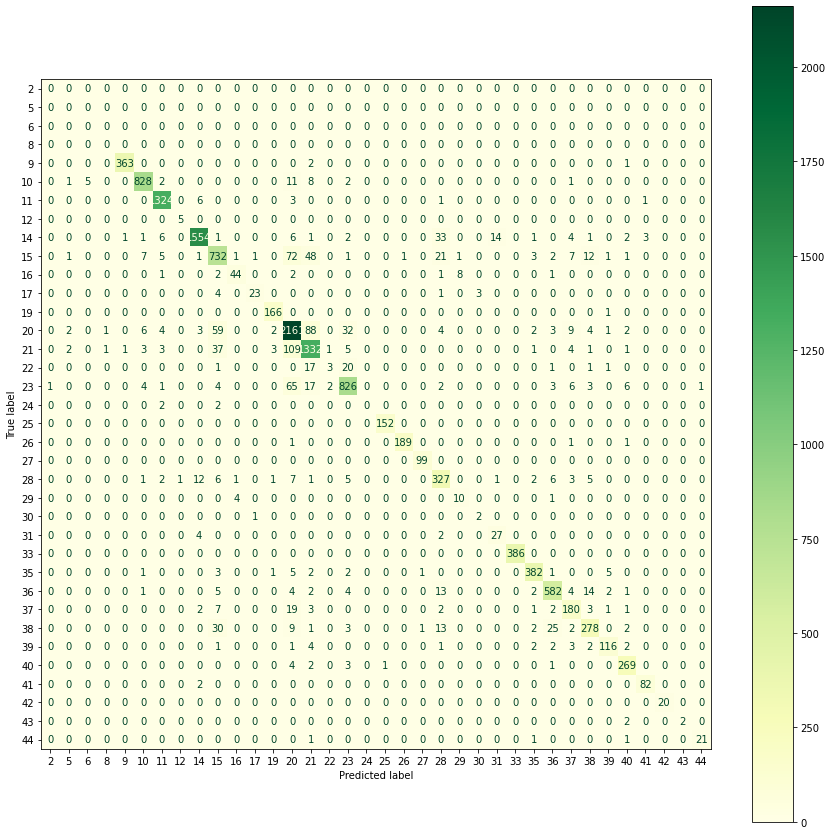

In [76]:
predictions_gru, cmatr_gru = compute_predictions(partial(build_GRU_model, COMPILING_INFO), 
    test_dataset, y_test, labels=KEEP_IDXS, show_confusion_matrix=True)

### Performance of the deeper-classifier model on the test set

Loading weights for model deeper_classification_model
Computing predictions using model deeper_classification_model
5/5 [==============================] - 1s 3ms/step
Computing evaluation F1-Score for model deeper_classification_model
	DEBUG:
	Predicted: [21 21 21  4 21 21  4 21  4 36 26 36 10 10 23  4  9 28 10 20]...
	Real:      [21 21 21  4 21 21  4 21  4 36 26 36 10 10 23  4  9 14 10 20]...
F1-Score (macro-weighted): 0.7392925095506728



/home/volpepe/Desktop/SequenceLabeling/.env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1570: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


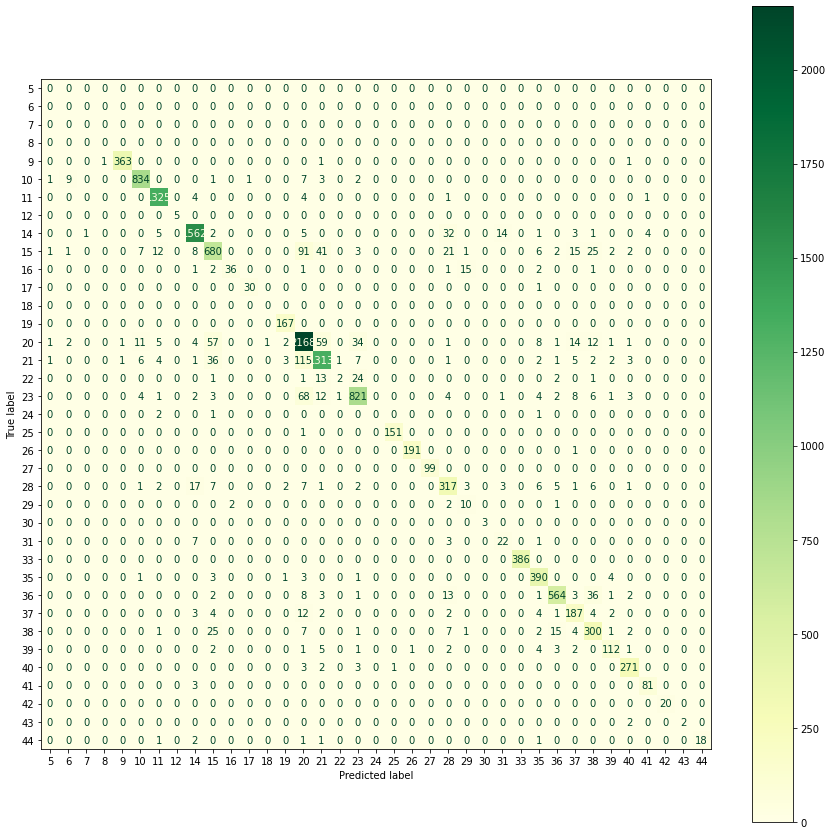

In [77]:
predictions_densex2, cmatr_densex2 = compute_predictions(partial(build_densex2_model, COMPILING_INFO), 
    test_dataset, y_test, labels=KEEP_IDXS, show_confusion_matrix=True)

### Comments

Some of the things we observe from the previous analysis:
- The F1-Score is similar to the scores we obtained on the validation set, so the training seems to have been successful.
- The model sometimes (rarely) predicts some legit tokens as punctuation.
- The largest mistakes of both our models seem to happen for labels 15, 20, 21, 23, 28, 38.
    - Groundtruth labels 20 and 21 are sometimes interchanged by our predictor, or confused with a 15.
    - Groundtruth labels 15 are also sometimes predicted as 20/21
    - Groundtruth labels 23 are sometimes predicted as 20/21 and viceversa
    - Groundtruth labels 28 are sometimes predicted as 14/15 and viceversa
    - 38 and 15 are also confused sometimes.
- Mistakes on the previously mentioned labels account for a great deal of the total errors. We can show this with the following code:

In [78]:
ERR_LABELS = [15, 20, 21, 23, 28, 38]
# Obtain the number of correct predictions by sampling on the diagonal from the 
# rows of the labels we are claiming to be full of errors.
# NOTE: the confusion matrix returned by the compute_predictions model are not 
# the same as those plotted above: instead, they contain all labels, so we can
# index them directly
ok_values_gru = cmatr_gru[ERR_LABELS, ERR_LABELS]
ok_values_dense = cmatr_densex2[ERR_LABELS, ERR_LABELS]
# Sum the total number of values in the matrix. It is the same for both matrices.
tot_vals = np.sum(cmatr_gru)
# Then, obtain how many errors are there in the whole matrix. 
# We can do this by subtracting from the total amount of examined labels,
# The sum of the labels that are on the diagonal of the matrix (the correctly
# predicted labels)
total_errors_gru = tot_vals - np.sum(np.diag(cmatr_gru))
total_errors_dense = tot_vals - np.sum(np.diag(cmatr_densex2))
# To understand how many errors are done on the rows of interest,
# we sum over the whole rows obtaining a vector of counts for each row,
# then we subtract the previously computed number of correct predictions
# for that row.
errors_gru = np.sum(np.sum(cmatr_gru[ERR_LABELS], axis=1) - ok_values_gru)
errors_dense = np.sum(np.sum(cmatr_densex2[ERR_LABELS], axis=1) - ok_values_dense)
# Finally, we normalize these results to obtain probabilities
norm_errors_gru = errors_gru / total_errors_gru
norm_errors_dense = errors_dense / total_errors_dense

print("Errors for problematic labels {} in the GRU model account for {:.2f}% of the total errors".format(ERR_LABELS, norm_errors_gru*100))
print("Errors for problematic labels {} in the deeper dense model account for {:.2f}% of the total errors".format(ERR_LABELS, norm_errors_dense*100))

Errors for problematic labels [15, 20, 21, 23, 28, 38] in the GRU model account for 70.28% of the total errors
Errors for problematic labels [15, 20, 21, 23, 28, 38] in the deeper dense model account for 71.75% of the total errors


These 6 tags are responsible for over $70\%$ of the mistakes of the models. To get a clearer view, these labels correspond to the following POS tags:

In [79]:
[idx_to_label(idx) for idx in [15, 20, 21, 23, 28, 38]]

['JJ', 'NN', 'NNP', 'NNS', 'RB', 'VBN']

Where:
- JJ (15) are Adjectives
- NN (20) are Singular Nouns
- NNP (21) are Proper Nouns
- NNS (23) are Plural Nouns
- RB (28) are Adverbs
- VBN (38) are Verbs at past principle

It makes sense that some singular nouns are confused with proper nouns, that there is some confusion between singular and plural and that the model has trouble understanding when adjectives are **actual** adjectives and when they are something else. We as humans often have the same problems!

Let's explore some of the sentences where the model makes such mistakes.

#### Error Exploration

With this utility function we can easily visualize a sentence, its groundtruth tags and the predicted tags.

We use the deeper-classifier model, which is the better performing one, but the confusion matrix for the GRU model tells us that similar results would be obtained.

In [86]:
prediction_array = np.argmax(predictions_densex2, axis=2)

def get_comparison(idx=None, verbose=True):
    # Call with no parameters to get random sentence
    if idx is None:
        idx = random.choice(range(len(test_sentences)))
    if verbose:
        print("Sentence: {}".format(get_natural_language_sentence(test_sentences[idx])))
    # Create dataframe for the comparison
    rand_df = test_sentences[idx].reset_index().drop(['index'], axis=1).T
    rand_pred = prediction_array[idx]
    # Drop whatever is after the point in the prediction
    rand_pred = rand_pred[0:np.where(rand_pred == 7)[0][0] + 1]
    # Appen the prediction to the last line
    rand_pred = pd.Series([ idx_to_label(idx) for idx in rand_pred ], name="prediction")
    rand_df = rand_df.append(rand_pred)
    return rand_df

# Eg. get a random comparison
random_comparison = get_comparison()
random_comparison

Sentence: the move is part of a strategy to focus on its core metals trading , processing and plant engineering activities while shedding peripheral units , the company said .


,0,1,2,3,4,5,6,7,8,9,...,19,20,21,22,23,24,25,26,27,28
word,the,move,is,part,of,a,strategy,to,focus,on,...,activities,while,shedding,peripheral,units,",",the,company,said,.
tag,DT,NN,VBZ,NN,IN,DT,NN,TO,VB,IN,...,NNS,IN,VBG,JJ,NNS,",",DT,NN,VBD,.
prediction,DT,NN,VBZ,NN,IN,DT,NN,TO,VB,IN,...,NNS,IN,VBG,JJ,NNS,",",DT,NN,VBD,.


With this function we can specify which errors we want to look for.

In [87]:
def select_comparisons_with_given_errors(check_gt_label=ERR_LABELS, 
                                         check_pred_label=ERR_LABELS, 
                                         num=5,
                                         use_indices:list=[]):
    count = 0
    skip = set()
    while count < num and len(skip) < len(test_sentences):
        if len(use_indices) == 0:
            # Get random comparisons until we found num satisfying the checks
            idx = np.random.randint(0, len(test_sentences))
        else:
            # Use an index from the list (for showing specific examples)
            idx = use_indices.pop(0)
        if idx not in skip:
            skip.add(idx)
            comparison = get_comparison(idx, verbose=False)
            # Translate them to indices
            try:
                mapped_pred = comparison.iloc[2,:].apply(labels_to_idx)
            except ValueError:
                display(comparison)
            mapped_gt = comparison.iloc[1,:].apply(labels_to_idx)
            # Obtain a map of where the predictions are wrong
            error_map = ~(mapped_pred == mapped_gt)
            # Check if any of the prediction is in the set of labels to be checked
            if np.any(np.isin(mapped_pred[error_map], check_pred_label)):
                # Check if any of the gt labels for those positions is in the set of labels to be checked
                gt_check = [idx for idx in np.where(error_map)[0] if mapped_pred[idx] in check_pred_label]
                if np.any(np.isin(mapped_gt[gt_check], check_gt_label)):
                    print("Index {}, Sentence: {}".format(idx, ' '.join(comparison.iloc[0, :])))
                    print("Matched error at index {}".format([idx for idx in gt_check if mapped_gt[idx] in check_gt_label]))
                    display(comparison)
                    count += 1

For example, we can find some examples of the model predicting a plural noun when the word was a singular noun.

In [88]:
select_comparisons_with_given_errors(check_gt_label=[20], check_pred_label=[23], num=4, use_indices=[191, 572, 595])

Index 191, Sentence: sales totaled 1.916 trillion yen , climbing 17 % from 1.637 trillion yen in the year-earlier period .
Matched error at index [12]


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17
word,sales,totaled,1.916,trillion,yen,",",climbing,17,%,from,1.637,trillion,yen,in,the,year-earlier,period,.
tag,NNS,VBD,CD,CD,NN,",",VBG,CD,NN,IN,CD,CD,NN,IN,DT,JJ,NN,.
prediction,NNS,VBD,CD,CD,NN,",",VBG,CD,NN,IN,CD,CD,NNS,IN,DT,JJ,NN,.


Index 137, Sentence: the company also cited interest costs and amortization of goodwill as factors in the loss .
Matched error at index [7, 9]


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
word,the,company,also,cited,interest,costs,and,amortization,of,goodwill,as,factors,in,the,loss,.
tag,DT,NN,RB,VBD,NN,NNS,CC,NN,IN,NN,IN,NNS,IN,DT,NN,.
prediction,DT,NN,RB,VBN,NN,NNS,CC,NNS,IN,NNS,IN,NNS,IN,DT,NN,.


Index 515, Sentence: ralston attributed its fourth-quarter slump partly to higher costs of ingredients in the pet food business as well as competitive pressures , which required higher advertising spending .
Matched error at index [26]


,0,1,2,3,4,5,6,7,8,9,...,18,19,20,21,22,23,24,25,26,27
word,ralston,attributed,its,fourth-quarter,slump,partly,to,higher,costs,of,...,as,competitive,pressures,",",which,required,higher,advertising,spending,.
tag,NNP,VBD,PRP$,NN,NN,RB,TO,JJR,NNS,IN,...,IN,JJ,NNS,",",WDT,VBD,JJR,NN,NN,.
prediction,NNP,VBD,PRP$,JJ,NN,RB,TO,JJR,NNS,IN,...,IN,JJ,NNS,",",WDT,RB,JJR,NN,NNS,.


Index 630, Sentence: '' the two professors represent different ends of the political spectrum -- mr. kurland is a conservative and mr. tribe is a liberal .
Matched error at index [10]


,0,1,2,3,4,5,6,7,8,9,...,14,15,16,17,18,19,20,21,22,23
word,'',the,two,professors,represent,different,ends,of,the,political,...,is,a,conservative,and,mr.,tribe,is,a,liberal,.
tag,'',DT,CD,NNS,VBP,JJ,NNS,IN,DT,JJ,...,VBZ,DT,JJ,CC,NNP,NNP,VBZ,DT,NN,.
prediction,'',DT,CD,NNS,VBP,JJ,NN,IN,DT,JJ,...,VBZ,DT,JJ,CC,NNP,NNP,VBZ,DT,JJ,.


The model confuses word about money for plural: it makes sense because they are predeced by plural numbers!

In other examples, though, the common pattern seems to be that the model may think that abstract concepts (volatility, demand, pricing, ...) are plural.

What about Adjectives and Adverbs?

In [89]:
# Adjectives are 15 (JJ), adverbs are 28 (RB)
select_comparisons_with_given_errors(check_gt_label=[15,28], check_pred_label=[15,28], num=3, use_indices=[532, 377])

Index 377, Sentence: it also hopes for ultimate gains of as much as $ 300 million on equity investments in buy-outs and restructurings .
Matched error at index [8]


,0,1,2,3,4,5,6,7,8,9,...,11,12,13,14,15,16,17,18,19,20
word,it,also,hopes,for,ultimate,gains,of,as,much,as,...,300,million,on,equity,investments,in,buy-outs,and,restructurings,.
tag,PRP,RB,VBZ,IN,JJ,NNS,IN,RB,JJ,IN,...,CD,CD,IN,NN,NNS,IN,NNS,CC,NNS,.
prediction,PRP,RB,VBZ,IN,JJ,NN,IN,RB,RB,IN,...,CD,CD,IN,NN,NNS,IN,JJ,CC,NNS,.


Index 7, Sentence: '' but mr. ackerman said the buy-back , and the above-market price paid , prove that mr. edelman is running scared .
Matched error at index [20]


,0,1,2,3,4,5,6,7,8,9,...,12,13,14,15,16,17,18,19,20,21
word,'',but,mr.,ackerman,said,the,buy-back,",",and,the,...,paid,",",prove,that,mr.,edelman,is,running,scared,.
tag,'',CC,NNP,NNP,VBD,DT,NN,",",CC,DT,...,VBN,",",VBP,IN,NNP,NNP,VBZ,VBG,JJ,.
prediction,'',CC,NNP,NNP,VBD,DT,NN,",",CC,DT,...,VBN,",",RB,DT,NNP,NNP,VBZ,VBG,RB,.


Index 81, Sentence: the soviets are widely believed to need additional supplies , despite running up record one-month purchases of 310 million bushels of corn in october .
Matched error at index [13]


,0,1,2,3,4,5,6,7,8,9,...,15,16,17,18,19,20,21,22,23,24
word,the,soviets,are,widely,believed,to,need,additional,supplies,",",...,purchases,of,310,million,bushels,of,corn,in,october,.
tag,DT,NNPS,VBP,RB,VBN,TO,VB,JJ,NNS,",",...,NNS,IN,CD,CD,NNS,IN,NN,IN,NNP,.
prediction,DT,NNS,VBP,RB,VBN,TO,VB,JJ,NNS,",",...,NNS,IN,CD,CD,NNS,IN,NN,IN,NNP,.


Much, enough, ... are all sources of problems because they can be both adjectives and adverbs depending on the context. It's a hard classification task even for humans. For example, we can see how many times the network gets the word "much" wrong and how:

JJ RB
JJ RB
JJ RB
RB RB
JJ JJ
JJ IN
JJ RB
JJ RB
JJ RB


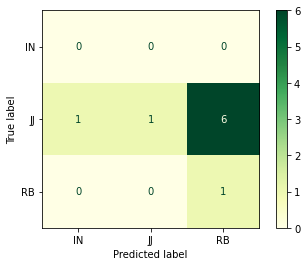

In [90]:
gt_tags = []
pred_tags = []

WORD = "much"

for i in range(len(test_sentences)):
    comparison = get_comparison(idx=i, verbose=False)
    for idx in np.where(comparison.T['word'].str.find(WORD) == 0)[0]:
        comp = comparison.T.iloc[idx, :].T
        real = comp['tag']
        pred = comp['prediction']
        gt_tags.append(real)
        pred_tags.append(pred)
        print(real, pred)
        
ConfusionMatrixDisplay.from_predictions(y_true=gt_tags, 
            y_pred=pred_tags, cmap='YlGn')

What about adjectives predicted as nouns and vice-versa?

In [91]:
select_comparisons_with_given_errors(check_gt_label=[15], check_pred_label=[20,21], num=2)
select_comparisons_with_given_errors(check_gt_label=[20,21], check_pred_label=[15], num=2)

Index 581, Sentence: in chile , workers at two copper mines , los bronces and el soldado , which belong to the exxon-owned minera disputada , yesterday voted to begin a full strike tomorrow , an analyst said .
Matched error at index [19]


,0,1,2,3,4,5,6,7,8,9,...,26,27,28,29,30,31,32,33,34,35
word,in,chile,",",workers,at,two,copper,mines,",",los,...,begin,a,full,strike,tomorrow,",",an,analyst,said,.
tag,IN,NNP,",",NNS,IN,CD,NN,NNS,",",NNP,...,VB,DT,JJ,NN,NN,",",DT,NN,VBD,.
prediction,IN,NNP,",",NNS,IN,CD,NN,NNS,",",NNP,...,VB,DT,JJ,NN,NN,",",DT,NN,VBD,.


Index 632, Sentence: moreover , they said the first appropriations bill passed 200 years ago covered many different items , and there was no discussion of a line-item veto .
Matched error at index [5]


,0,1,2,3,4,5,6,7,8,9,...,17,18,19,20,21,22,23,24,25,26
word,moreover,",",they,said,the,first,appropriations,bill,passed,200,...,and,there,was,no,discussion,of,a,line-item,veto,.
tag,RB,",",PRP,VBD,DT,JJ,NNS,NN,VBN,CD,...,CC,EX,VBD,DT,NN,IN,DT,JJ,NN,.
prediction,RB,",",PRP,VBD,DT,NNP,NNP,NN,VBD,CD,...,CC,EX,VBD,DT,NN,IN,DT,JJ,NN,.


Index 179, Sentence: old spaghetti warehouse rose 1 to 16 1\/8 .
Matched error at index [0]


,0,1,2,3,4,5,6,7,8
word,old,spaghetti,warehouse,rose,1,to,16,1\/8,.
tag,NNP,NNP,NNP,VBD,CD,TO,CD,CD,.
prediction,JJ,NN,NN,NN,CD,TO,CD,CD,.


Index 193, Sentence: atsushi muramatsu , executive vice president and chief financial officer of nissan , said , `` the company has experienced a remarkable turnaround in terms of profitability since the fiscal year ending march 1987 , when the sharp and rapid appreciation of the yen caused many difficulties .
Matched error at index [7]


,0,1,2,3,4,5,6,7,8,9,...,38,39,40,41,42,43,44,45,46,47
word,atsushi,muramatsu,",",executive,vice,president,and,chief,financial,officer,...,and,rapid,appreciation,of,the,yen,caused,many,difficulties,.
tag,NNP,NNP,",",JJ,NN,NN,CC,NN,JJ,NN,...,CC,JJ,NN,IN,DT,NN,VBD,JJ,NNS,.
prediction,NNP,NNP,",",JJ,NN,NN,CC,JJ,JJ,NN,...,CC,JJ,NN,IN,DT,NN,VBN,JJ,VBG,.


We notice that some of the adjectives are pretty specific and complex, so the model may have thought they were representative enough to be nouns. Also, some adjectives are also commonly used as nouns and viceversa, causing some problems.